In [3]:
!pip install pillow-heif ipycanvas
!pip install -q gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 9.1 MB/s eta 0:00:00


## Downloading and Setting Up Required Files

This cell downloads the input images (to be used for neural style transfer) and the style images from our shared Google Drive folders into local directories. It also creates local directories for input images, style images, and the output images if they don't already exist. This ensures that all required files are available in the correct locations for subsequent processing.


In [111]:
import os

input_local_dir = "input_images"
style_local_dir = "style_images"
output_local_dir = "output"

os.makedirs(input_local_dir, exist_ok=True)
os.makedirs(style_local_dir, exist_ok=True)
os.makedirs(output_local_dir, exist_ok=True)

input_drive_link = "https://drive.google.com/drive/folders/1KKmsZNC5U1-Ug6RB4WQw0yQWbY50jT9u"
style_drive_link = "https://drive.google.com/drive/folders/1LAxoUhwt1eiqqC2TzlJ1VdUpMUgyhV4i?usp=sharing"

!gdown --folder "{input_drive_link}" -O {input_local_dir}
!gdown --folder "{style_drive_link}" -O {style_local_dir}

Retrieving folder contents
Processing file 1OuUtVeEJF50TGW0WbV_eEev8a0r8MGJu IMG_1620.png
Processing file 1m_FxBKDorue9HediaaIas-IdxKs0wTJp IMG_1621.png
Processing file 1H4FJoTwfAIlDnZQFYMlcQO17kjNgmC1R IMG_1622.png
Processing file 1wZv5X6tHntbOlRLzuWoUrI1B8p1t9k_T IMG_1623.png
Processing file 1xumsCbs7wGG7oouoMJNMGQqiiRgA-O8R IMG_1624.png
Processing file 1Emq5qv3TAUHNgjsRv3UJkjo7oZtBAxvR IMG_1625.png
Processing file 1oaxnhUpEhofppazsON0He67IAq-5eQV7 IMG_1626.png
Processing file 1bzOc0SE0WD8huQsIulh_TAhfDJflmIIz IMG_1627.png
Processing file 1vXKKvVH5GaMgEFVtcE8wOJNBS2cMjUnY IMG_1629.png
Processing file 1rMyAMNRWIL5JK4re456C0Gpe2eS9lSTW IMG_1630.png
Processing file 1HDppqRtwo1kPFOBXumaLnhv0B8O_Lb0A IMG_1631.png
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1OuUtVeEJF50TGW0WbV_eEev8a0r8MGJu
To: /kaggle/working/input_images/IMG_1620.png
100%|██████████████████████████████████████

In [112]:
!ls style_images

blue_marble.png  inspo.png


## Neural Style Transfer Library

This cell contains the core implementation of our neural style transfer pipeline. Below is a high-level overview of what it does:

- **Device Setup and Image Loading:**  
  It sets the main computation device (using GPU if available) and defines a `load_image` function that loads an image, resizes and center-crops it, converts it to a tensor, and moves it to the chosen device.

- **Normalization and Loss Classes:**  
  The `Normalization` class standardizes images using given mean and standard deviation values. The `ContentLoss` and `StyleLoss` classes compute the respective losses needed for style transfer, with the style loss using a `gram_matrix` function to capture texture information.

- **Model Construction:**  
  The `get_style_model_and_losses` function builds a modified VGG19 model by inserting the content and style loss layers at specific points. This model is then used to extract features and compute losses during the optimization process.

- **Optimization:**  
  The `get_input_optimizer` function sets up an LBFGS optimizer. The `run_style_transfer` function iteratively updates the input image to minimize a weighted combination of the content and style losses. A tqdm progress bar is used to show the current iteration progress and display the content loss at each step.

- **Overall Process Orchestration:**  
  The `process_style_transfer` function ties everything together. It reads the content and style images from specified directories (with support for processing multiple style images if desired), applies the style transfer to each image, and saves the resulting stylized images in the output directory.

In [101]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Image Loading
# ---------------------------
def load_image(image_path, target_size=512):
    image = Image.open(image_path).convert('RGB')
    transform_pipeline = transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
    ])
    image_tensor = transform_pipeline(image).unsqueeze(0)
    return image_tensor.to(device)

# ---------------------------
# 2. Loss / Normalization
# ---------------------------
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)
    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input_tensor):
    b, ch, h, w = input_tensor.size()
    features = input_tensor.view(b * ch, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * ch * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Default layers used to compute content/style losses
content_layers_default = ['conv_4']
style_layers_default   = ['conv_1','conv_2','conv_3','conv_4','conv_5']

# ---------------------------
# 3. Model Construction
# ---------------------------
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Truncate the network after the last loss
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j + 1)]
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# ---------------------------
# 4. Running the Transfer
# ---------------------------
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       num_steps=300, style_weight=1_000_000, content_weight=1,
                       snapshots=None, style_subdir=None, base_content=None):
    """
    snapshots: list of iteration steps at which to save an intermediate image.
    style_subdir: directory where the style images will be saved (based on style image name).
    base_content: base name of the content image for naming output files.
    """
    if snapshots is None:
        snapshots = []

    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )

    optimizer = get_input_optimizer(input_img)
    pbar = tqdm(total=num_steps, desc="Style Transfer", unit="iter")
    run_iter = 0

    while run_iter < num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)

            style_score = 0.0
            content_score = 0.0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            return loss

        optimizer.step(closure)
        run_iter += 1
        current_content_loss = sum(cl.loss.item() for cl in content_losses)

        # Show loss in tqdm bar
        pbar.set_postfix({'Content Loss': f"{current_content_loss:.4f}"})
        pbar.update(1)

        # Check if this iteration is in our snapshot list
        if (run_iter in snapshots) and style_subdir and base_content:
            save_snapshot(input_img, run_iter, style_subdir, base_content)

    pbar.close()

    # Save final (if the final iteration is not already in snapshots)
    if (num_steps not in snapshots) and style_subdir and base_content:
        save_snapshot(input_img, num_steps, style_subdir, base_content)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def save_snapshot(input_img, iteration, style_subdir, base_content):
    """
    Saves the current state of the stylized image to a subdirectory named `step_<iteration>`.
    """
    # Create subdirectory for this iteration
    step_dir = os.path.join(style_subdir, f"step_{iteration}")
    os.makedirs(step_dir, exist_ok=True)

    # Clamp and convert to PIL
    with torch.no_grad():
        input_img.clamp_(0, 1)
    snapshot_tensor = input_img.cpu().squeeze(0)
    snapshot_image = transforms.ToPILImage()(snapshot_tensor)

    snapshot_filename = f"{base_content}_styled_{iteration}.png"
    snapshot_path = os.path.join(step_dir, snapshot_filename)
    snapshot_image.save(snapshot_path)
    print(f"  Snapshot saved at iteration {iteration}: {snapshot_path}")

# ---------------------------
# 5. High-Level Processing
# ---------------------------
def process_style_transfer(config):
    """
    Processes PNG content images from config["input_dir"], stylizing them with the specified style image (config["style_img"]).
    Saves multiple snapshots at specified iteration steps (config["snapshots"]).
    Results are placed in a subdirectory named after the style image (minus the extension).
    """
    # Validate style image
    style_img_path = config["style_img"]
    if not os.path.exists(style_img_path):
        raise ValueError(f"Style image not found: {style_img_path}")
    # Parse style image base name
    style_basename = os.path.splitext(os.path.basename(style_img_path))[0]

    # Create the style subdirectory inside output
    style_subdir = os.path.join(config["output_dir"], style_basename)
    os.makedirs(style_subdir, exist_ok=True)

    # Collect content images
    content_files = [f for f in os.listdir(config["input_dir"]) if f.lower().endswith(".png")]
    if not content_files:
        raise ValueError("No PNG content images found in the input directory.")

    max_files = config.get("max_files", None)
    if max_files is not None:
        content_files = content_files[:max_files]

    # Load CNN model
    cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
    cnn_mean = [0.485, 0.456, 0.406]
    cnn_std  = [0.229, 0.224, 0.225]

    # Load style image
    style_img = load_image(style_img_path, target_size=config.get("target_size", 512))

    # Process each content image
    for content_file in content_files:
        print(f"Processing content image: {content_file}...")
        content_image_path = os.path.join(config["input_dir"], content_file)
        content_img = load_image(content_image_path, target_size=config.get("target_size", 512))

        # Prepare the input (we optimize starting from content_img)
        input_img = content_img.clone()

        base_content, _ = os.path.splitext(content_file)

        # Run style transfer
        _ = run_style_transfer(
            cnn, cnn_mean, cnn_std,
            content_img, style_img, input_img,
            num_steps=config.get("num_steps", 300),
            style_weight=config.get("style_weight", 1_000_000),
            content_weight=config.get("content_weight", 1),
            snapshots=config.get("snapshots", []),
            style_subdir=style_subdir,
            base_content=base_content
        )


## Configure Settings

This cell allows you to configure the parameters for our neural style transfer experiments. Below is a brief explanation of each parameter:

- **input_dir**:  
  The local directory where the content images (to be stylized) are stored.

- **output_dir**:  
  The local directory where the resulting stylized images will be saved.

- **style_dir**:  
  The local directory containing the style images used for transfer.

- **num_steps**:  
  The number of iterations for the optimization process. A higher value generally produces a more refined and pronounced style transfer effect, while a lower value yields a subtler result.

- **style_weight**:  
  The weight applied to the style loss. This parameter controls the strength of the style features in the output.

- **content_weight**:  
  The weight applied to the content loss. This parameter controls how closely the output image retains the structure of the original content image.

- **target_size**:  
  The size (in pixels) to which images are resized before processing. This helps standardize the input size.

- **max_files**:  
  Limits the number of content images processed from the input directory. Set this to `None` to process all images.

- **style_mode**:  
  Determines whether to use only the first style image ("single") or process all available style images ("multiple").

Feel free to experiment mainly with `num_steps` to observe how the number of iterations affects the final stylized image.


In [113]:
config = {
    "input_dir": "input_images",
    "output_dir": "output",
    "style_img": "/kaggle/working/style_images/inspo.png",  # Exact style image path
    "num_steps": 40,              # Number of iterations; higher values yield stronger style effects
    "style_weight": 1_000_000,
    "content_weight": 1,
    "target_size": 512,
    "max_files": 1,
    "snapshots": [10, 25, 40],    # Iterations where intermediate images are saved
}


## Style Transfer

In [114]:
process_style_transfer(config)

Processing content image: IMG_1625.png...


Style Transfer:  25%|██▌       | 10/40 [00:14<00:45,  1.53s/iter, Content Loss=9.3868]

  Snapshot saved at iteration 10: output/inspo/step_10/IMG_1625_styled_10.png


Style Transfer:  62%|██████▎   | 25/40 [00:38<00:23,  1.55s/iter, Content Loss=6.3712]

  Snapshot saved at iteration 25: output/inspo/step_25/IMG_1625_styled_25.png


Style Transfer: 100%|██████████| 40/40 [01:01<00:00,  1.53s/iter, Content Loss=5.9814]

  Snapshot saved at iteration 40: output/inspo/step_40/IMG_1625_styled_40.png


## Visualizing Processed Results

After running the style transfer process, you can visualize one of the resulting images directly in the notebook. This cell uses IPython's display functions to load and display an image from the output directory. Simply update the file path (in the code cell below) to match one of the processed images, and then run the cell to see the result.

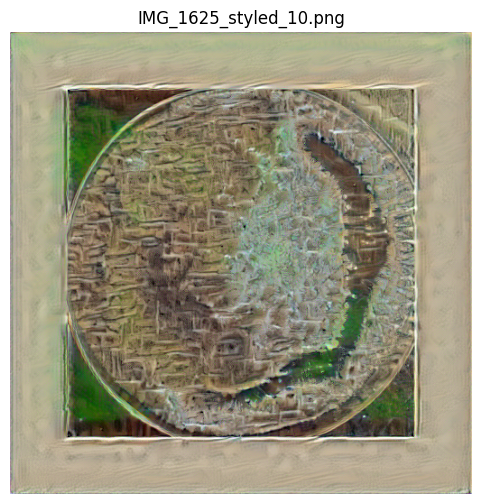

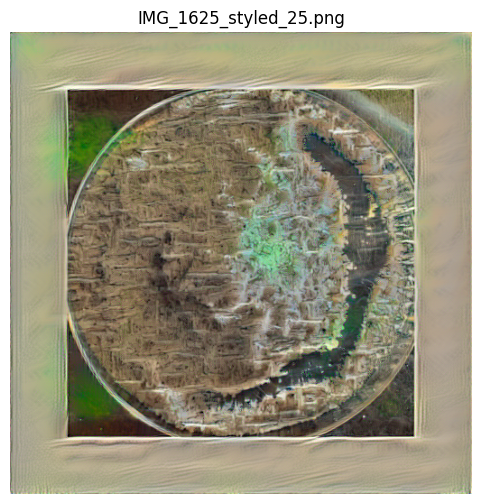

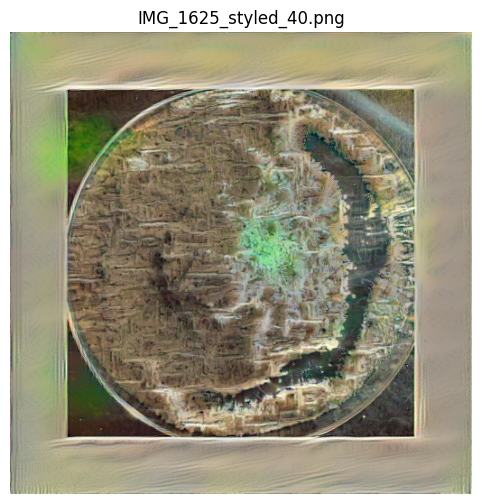

In [118]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def visualize_outputs(output_dir, figsize=(8, 6)):
    """
    Recursively finds all PNG images in `output_dir` and displays each one individually.
    
    Parameters:
      output_dir (str): The directory where the output images are stored.
      figsize (tuple): Figure size for each image display.
    """
    # Recursively gather all .png image paths
    image_paths = []
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append(os.path.join(root, file))
    
    # Sort the image paths for consistent order
    image_paths.sort()
    
    if not image_paths:
        print("No images found in", output_dir)
        return
    
    # Display each image individually
    for img_path in image_paths:
        img = Image.open(img_path)
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=12)
        plt.axis('off')
        plt.show()

# Example usage:
visualize_outputs('/kaggle/working/output/inspo')

## Download the Results

In [119]:
import os
import shutil
from google.colab import files

def download_images_zip(target_dir, zip_filename="download.zip"):
    """
    Recursively compresses all files in `target_dir` into a zip file and triggers a download.
    
    Parameters:
      target_dir (str): The directory containing the images to be zipped.
      zip_filename (str): The name for the resulting zip file (default is "download.zip").
    """
    if not os.path.exists(target_dir):
        print("Directory does not exist:", target_dir)
        return
    
    # Remove extension from zip_filename for base name, if provided.
    base_name = os.path.splitext(zip_filename)[0]
    
    # Create a zip archive of the target_dir.
    # The archive will be named `base_name.zip`
    shutil.make_archive(base_name, 'zip', root_dir=target_dir)
    
    print(f"Created {zip_filename}")
    
    # Trigger a download of the zip file.
    files.download(zip_filename)

# Example usage:
download_images_zip('/kaggle/working/output/inspo', zip_filename="inspo.zip")

Created inspo.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>